<a href="https://colab.research.google.com/github/cemdenizsel/Financial-Sentiment-Analysis-with-Transformer-Based-Models/blob/main/Test_XLNET_with_FIQA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
-from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -qq transformers

     |████████████████████████████████| 2.3MB 14.5MB/s 
     |████████████████████████████████| 901kB 48.8MB/s 
     |████████████████████████████████| 3.3MB 51.8MB/s 


In [ ]:
% pip install sentencepiece

     |████████████████████████████████| 1.2MB 13.7MB/s 


In [ ]:
import transformers

import torch
import pandas as pd
import numpy as np
import torch.nn.functional as F

from sklearn.metrics import confusion_matrix, classification_report
from torch.utils.data import Dataset, DataLoader
from transformers import XLNetTokenizer
from sklearn import metrics


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
scores = pd.read_csv('/content/drive/MyDrive/FIQA/scores.txt', sep='delimiter',names=["sentiment"] ,header = None )
sentences = pd.read_csv('/content/drive/MyDrive/FIQA/sentences.txt',sep='delimiter',header = None, names=['sentences'])
df = pd.concat([sentences , scores], axis=1, join='inner')
df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


,sentences,sentiment
0,Royal Mail chairman Donald Brydon set to step ...,-0.374
1,Stakes High for AstraZeneca Heart Drug Facing ...,-0.240
2,UPDATE 1-Dairy Crest loses a third of Morrison...,-0.161
3,Insight hires Aviva's David Hillier for multi-...,0.137
4,Primark racks up a happy Christmas after stron...,0.704
...,...,...
433,"Aviva, M&G suspend property funds as investors...",-0.807
434,"UK housing market steadies after Brexit dip, P...",0.339
435,BRIEF-Aviva aims to increase dividend pay-out ...,0.439
436,Builder Persimmon hails 6% rise in house sales,0.435


In [ ]:
def change_scores2_sentiments(score):
  if score <-0.33:
    return 0
  elif score > -0.33 and score <0.33:
    return 1
  else:
    return 2
df['sentiment'] = df['sentiment'].apply(change_scores2_sentiments)
df

,sentences,sentiment
0,Royal Mail chairman Donald Brydon set to step ...,0
1,Stakes High for AstraZeneca Heart Drug Facing ...,1
2,UPDATE 1-Dairy Crest loses a third of Morrison...,1
3,Insight hires Aviva's David Hillier for multi-...,1
4,Primark racks up a happy Christmas after stron...,2
...,...,...
433,"Aviva, M&G suspend property funds as investors...",0
434,"UK housing market steadies after Brexit dip, P...",2
435,BRIEF-Aviva aims to increase dividend pay-out ...,2
436,Builder Persimmon hails 6% rise in house sales,2


In [ ]:
from transformers import XLNetTokenizer, XLNetModel
import torch
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')
token_lens = []

for txt in df['sentences']:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [ ]:
class SentencesDataset(Dataset):

    def __init__(self, sentences, targets, tokenizer, max_len):
        self.sentences = sentences
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.sentences)
    
    def __getitem__(self, item):
        sentence = str(self.sentences[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
        sentence,
        add_special_tokens=True,
        max_length=self.max_len,
        return_token_type_ids=False,
        pad_to_max_length=False,
        return_attention_mask=True,
        return_tensors='pt',
        )

        input_ids = pad_sequences(encoding['input_ids'], maxlen=MAX_LEN, dtype=torch.Tensor ,truncating="post",padding="post")
        input_ids = input_ids.astype(dtype = 'int64')
        input_ids = torch.tensor(input_ids) 

        attention_mask = pad_sequences(encoding['attention_mask'], maxlen=MAX_LEN, dtype=torch.Tensor ,truncating="post",padding="post")
        attention_mask = attention_mask.astype(dtype = 'int64')
        attention_mask = torch.tensor(attention_mask)       

        return {
        'sentence_text': sentence,
        'input_ids': input_ids.flatten(),
        'attention_mask': attention_mask.flatten(),
        'targets': torch.tensor(target, dtype=torch.long)
        }

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = SentencesDataset(
    sentences=df.sentences.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=2
  )

In [ ]:
BATCH_SIZE = 16
MAX_LEN = 128

In [ ]:
test_data_loader = create_data_loader(df, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
from transformers import XLNetForSequenceClassification
model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels = 3)
model = model.to(device)

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.weight', 'sequence_summary.summary.weight', 'logits_proj.bias', 'sequence_summary.summary.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

In [ ]:
model.load_state_dict(torch.load('/content/drive/My Drive/Imdb/models/xlnet_model.bin'))

<All keys matched successfully>

In [ ]:
model = model.to(device)

In [ ]:
def get_predictions(model, data_loader):
    model = model.eval()
    
    sentence_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:

          texts = d["sentence_text"]
          input_ids = d["input_ids"].to(device)
          attention_mask = d["attention_mask"].to(device)
          targets = d["targets"].to(device)
            
          outputs = model(input_ids=input_ids,
                            token_type_ids=None,
                            attention_mask=attention_mask,
                            labels = targets)

          loss = outputs[0]
          logits = outputs[1]
            
          _, preds = torch.max(outputs[1], dim=1)

          probs = F.softmax(outputs[1], dim=1)

          sentence_texts.extend(texts)
          predictions.extend(preds)
          prediction_probs.extend(probs)
          real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return sentence_texts, predictions, prediction_probs, real_values

In [ ]:
def eval_model(model, data_loader, device, n_examples):
    model = model.eval()
    losses = []
    acc = 0
    counter = 0
  
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            outputs = model(input_ids=input_ids, token_type_ids=None, attention_mask=attention_mask, labels = targets)
            loss = outputs[0]
            logits = outputs[1]

            _, prediction = torch.max(outputs[1], dim=1)
            targets = targets.cpu().detach().numpy()
            prediction = prediction.cpu().detach().numpy()
            accuracy = metrics.accuracy_score(targets, prediction)

            acc += accuracy
            losses.append(loss.item())
            counter += 1

    return acc / counter, np.mean(losses)

In [ ]:
test_acc, test_loss = eval_model(
  model,
  test_data_loader,
  device,
  len(df)
)

print('Test Accuracy :', test_acc)
print('Test Loss :', test_loss)

Test Accuracy : 0.6882440476190476
Test Loss : 1.491499485714095


In [ ]:
from keras.preprocessing.sequence import pad_sequences

In [ ]:
y_headline_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
class_names = ["negative","neutral","positive"]

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.62      0.83      0.71        82
     neutral       0.71      0.69      0.70       227
    positive       0.69      0.58      0.63       129

    accuracy                           0.68       438
   macro avg       0.68      0.70      0.68       438
weighted avg       0.69      0.68      0.68       438



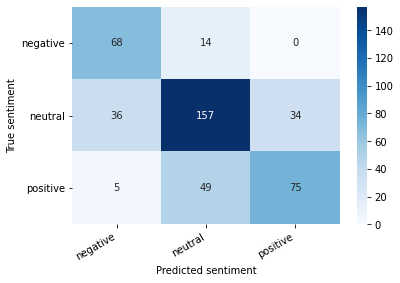

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)